In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.image as mpimg


import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image


In [2]:
dev = None
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)

/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272126608/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
device

device(type='cpu')

In [4]:
# Parameters
batch_size = 64
image_size = 64

eps=1e-7
# z_size = 50
# ngf=32
# nc = 1

# Root directory for dataset
dataroot = "./pokemon"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 96

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 96

# Number of training epochs
num_epochs = 15

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Dataset

In [5]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = [img for img in os.listdir(main_dir) if img.lower().endswith(".png") and "-back-" not in img and os.stat(os.path.join(main_dir, img)).st_size > 2000]
        self.total_imgs = sorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGBA")
        tensor_image = self.transform(image)
        return tensor_image


In [6]:
transform = transforms.Compose(
    [transforms.Resize((image_size,image_size)), transforms.CenterCrop(image_size), transforms.RandomHorizontalFlip(), torchvision.transforms.functional.to_grayscale, transforms.ToTensor(), transforms.Normalize((0.5), (0.5)),]
) #transforms.Resize(image_size),
# Try a few different normalizations
# and make sure generators output to the same range, then generator doesn't have to learn range

In [7]:
img_folder_path = "./pokemon"

In [8]:
my_dataset = CustomDataSet(img_folder_path, transform=transform)
trainloader = torch.utils.data.DataLoader(my_dataset , batch_size=batch_size, shuffle=True, 
                               num_workers=4, drop_last=True)


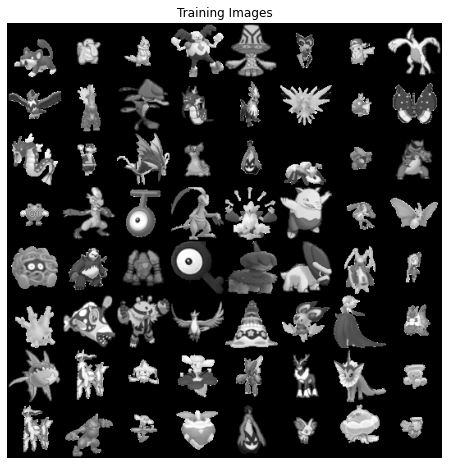

In [9]:
real_batch = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [11]:
len(trainloader)

117

# Networks

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
class DiscriminatorConvNet(nn.Module):    
    def __init__(self):
        super(DiscriminatorConvNet, self).__init__()

        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            
            nn.Conv2d(ndf * 8, ndf * 16, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 16),
#             nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten(start_dim=1)
        )
    

    def forward(self, x):
        return self.main(x)

D = DiscriminatorConvNet().to(device)
# D.apply(weights_init)
D

DiscriminatorConvNet(
  (main): Sequential(
    (0): Conv2d(1, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(384, 768, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(768, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1536, ep

In [14]:
# test input
inp = torch.randn(2,nc,image_size,image_size).to(device)
d_out = D(inp)
print(d_out)
d_image_out = D(real_batch.to(device))
print(d_image_out.shape)

tensor([[0.5615],
        [0.6230]], grad_fn=<ReshapeAliasBackward0>)
torch.Size([96, 1])


# Define the generator network

In [15]:
class GeneratorConvNet(nn.Module):
    def __init__(self):
        super(GeneratorConvNet, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
#             nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
#             nn.Conv2d(ngf * 8, ngf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 4, ngf*2, 4, 2,1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            
            nn.Conv2d(ngf * 2, ngf * 2, 5, 1, 2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            
            nn.Conv2d(ngf, ngf, 5, 1, 2, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ngf, ngf, 5, 1, 2, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, x):
        return self.main(x)

G = GeneratorConvNet().to(device)
# G.apply(weights_init)
G

GeneratorConvNet(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [16]:
# test input
inp = torch.randn(2, nz, 1, 1).to(device)
g_out = G(inp)
print(g_out.shape)

torch.Size([2, 1, 64, 64])


In [17]:
# Try running G out through D
d_of_g_out = D(g_out)
print(d_of_g_out)

tensor([[0.5154],
        [0.5450]], grad_fn=<ReshapeAliasBackward0>)


In [18]:
noise_generator = lambda x: torch.FloatTensor(x, nz, 1, 1).uniform_(0, 1) # pg(z) torch.randn(x, z_size)
noise_generator(2).shape

torch.Size([2, 100, 1, 1])

# Train algorithm

In [19]:
# Define the train parameters
# num_epochs = 12
# batch_size = 128
k_steps = 1
num_val_batches = 10


In [20]:
dataloader = trainloader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True, 
                               num_workers=4, drop_last=True)

#pdata(x)
# train_real_sampler = iter(trainloader)
# val_real_sampler = train_real_sampler

In [21]:
# pg(z)
noise_generator = lambda x: torch.FloatTensor(x, nz, 1, 1).to(device)
noise_generator(2).shape

torch.Size([2, 100, 1, 1])

In [22]:
optimizerD = optim.Adam(D.parameters(), lr=lr/5, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

In [23]:
D.to(device)
G.to(device)

# G.apply(weights_init)
# D.apply(weights_init)

GeneratorConvNet(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [24]:
criterion = nn.BCELoss()
real_label = 1.
fake_label = 0.

fixed_noise = torch.randn(64, nz, 1, 1, device=device)


In [25]:
def save_checkpoint(path, epoch, net, optimizer, loss):
    torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path)

def load_from_checkpoint(path, model, optimizer):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss


Starting Training Loop...
[0/15][0/117]	Loss_D: 1.5403	Loss_G: 1.1112	D(x): 0.4967	D(G(z)): 0.5534 / 0.3379


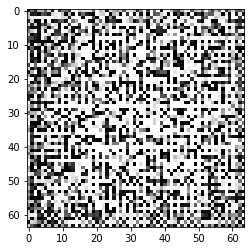

[0/15][50/117]	Loss_D: 0.9569	Loss_G: 4.1635	D(x): 0.9138	D(G(z)): 0.4927 / 0.0288
[0/15][100/117]	Loss_D: 0.9990	Loss_G: 3.9280	D(x): 0.7748	D(G(z)): 0.4588 / 0.0282


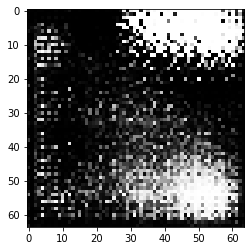

[1/15][0/117]	Loss_D: 0.8878	Loss_G: 2.8831	D(x): 0.8076	D(G(z)): 0.4505 / 0.0750
[1/15][50/117]	Loss_D: 1.1135	Loss_G: 2.6954	D(x): 0.5639	D(G(z)): 0.3265 / 0.0914


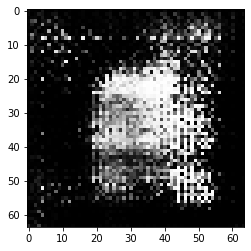

[1/15][100/117]	Loss_D: 1.0869	Loss_G: 1.7345	D(x): 0.6601	D(G(z)): 0.4550 / 0.1973
[2/15][0/117]	Loss_D: 1.3472	Loss_G: 1.1696	D(x): 0.4622	D(G(z)): 0.3889 / 0.3363
[2/15][50/117]	Loss_D: 1.2851	Loss_G: 1.1289	D(x): 0.5010	D(G(z)): 0.4114 / 0.3410


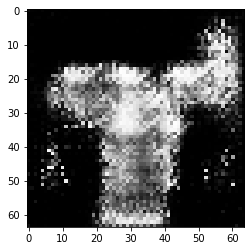

[2/15][100/117]	Loss_D: 1.3124	Loss_G: 1.5810	D(x): 0.5700	D(G(z)): 0.4945 / 0.2267
[3/15][0/117]	Loss_D: 1.4181	Loss_G: 1.0649	D(x): 0.5433	D(G(z)): 0.5095 / 0.3614


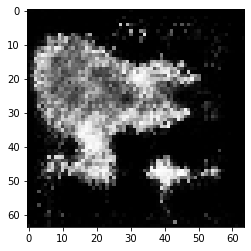

[3/15][50/117]	Loss_D: 1.2645	Loss_G: 1.1488	D(x): 0.4960	D(G(z)): 0.3884 / 0.3381
[3/15][100/117]	Loss_D: 1.3835	Loss_G: 0.9499	D(x): 0.4417	D(G(z)): 0.3524 / 0.4097
[4/15][0/117]	Loss_D: 1.3718	Loss_G: 0.8232	D(x): 0.4665	D(G(z)): 0.4210 / 0.4558


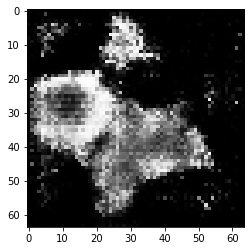

[4/15][50/117]	Loss_D: 1.1011	Loss_G: 1.3009	D(x): 0.5599	D(G(z)): 0.3739 / 0.2975
[4/15][100/117]	Loss_D: 1.3643	Loss_G: 0.8001	D(x): 0.4915	D(G(z)): 0.4443 / 0.4640
[5/15][0/117]	Loss_D: 1.3848	Loss_G: 1.0737	D(x): 0.5459	D(G(z)): 0.5140 / 0.3571


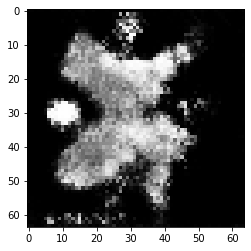

[5/15][50/117]	Loss_D: 1.4076	Loss_G: 0.9953	D(x): 0.4616	D(G(z)): 0.4319 / 0.3825
[5/15][100/117]	Loss_D: 1.3476	Loss_G: 0.8764	D(x): 0.4694	D(G(z)): 0.4092 / 0.4273


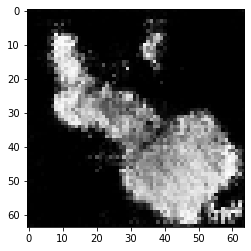

[6/15][0/117]	Loss_D: 1.1984	Loss_G: 1.1765	D(x): 0.5451	D(G(z)): 0.4173 / 0.3265
[6/15][50/117]	Loss_D: 1.3704	Loss_G: 1.0774	D(x): 0.5667	D(G(z)): 0.5241 / 0.3561


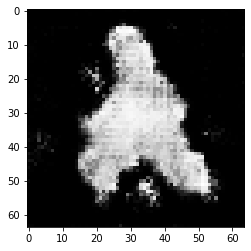

[6/15][100/117]	Loss_D: 1.2642	Loss_G: 1.0263	D(x): 0.4712	D(G(z)): 0.3646 / 0.3739
[7/15][0/117]	Loss_D: 1.1551	Loss_G: 1.2577	D(x): 0.6026	D(G(z)): 0.4520 / 0.3017
[7/15][50/117]	Loss_D: 1.2938	Loss_G: 1.4068	D(x): 0.5935	D(G(z)): 0.5111 / 0.2587


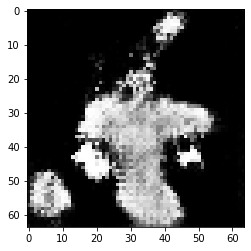

[7/15][100/117]	Loss_D: 1.2013	Loss_G: 1.0855	D(x): 0.5149	D(G(z)): 0.3929 / 0.3534
[8/15][0/117]	Loss_D: 1.2984	Loss_G: 0.9576	D(x): 0.5347	D(G(z)): 0.4527 / 0.4006
[8/15][50/117]	Loss_D: 1.2189	Loss_G: 1.1971	D(x): 0.5825	D(G(z)): 0.4653 / 0.3191


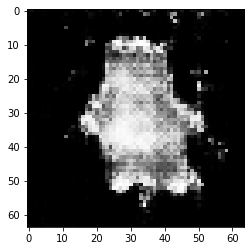

[8/15][100/117]	Loss_D: 1.2411	Loss_G: 1.5008	D(x): 0.6180	D(G(z)): 0.4987 / 0.2464
[9/15][0/117]	Loss_D: 1.2707	Loss_G: 1.1632	D(x): 0.5868	D(G(z)): 0.4955 / 0.3325


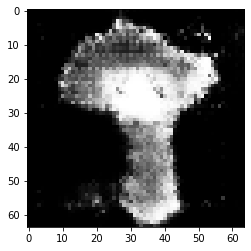

[9/15][50/117]	Loss_D: 1.2973	Loss_G: 1.1170	D(x): 0.5580	D(G(z)): 0.4842 / 0.3428
[9/15][100/117]	Loss_D: 1.4112	Loss_G: 1.0798	D(x): 0.5239	D(G(z)): 0.4976 / 0.3579
[10/15][0/117]	Loss_D: 1.3419	Loss_G: 1.3758	D(x): 0.5757	D(G(z)): 0.5176 / 0.2728


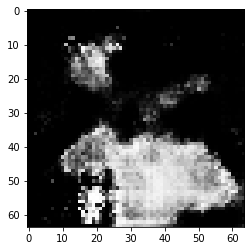

[10/15][50/117]	Loss_D: 1.2391	Loss_G: 1.3547	D(x): 0.6065	D(G(z)): 0.4854 / 0.2792
[10/15][100/117]	Loss_D: 1.1826	Loss_G: 1.2607	D(x): 0.6041	D(G(z)): 0.4611 / 0.3036
[11/15][0/117]	Loss_D: 1.2957	Loss_G: 0.9389	D(x): 0.4926	D(G(z)): 0.4061 / 0.4115


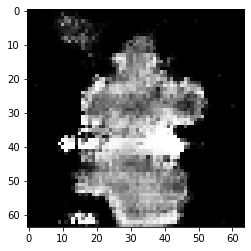

[11/15][50/117]	Loss_D: 1.2630	Loss_G: 1.2211	D(x): 0.6164	D(G(z)): 0.5092 / 0.3085
[11/15][100/117]	Loss_D: 1.3298	Loss_G: 1.1922	D(x): 0.5767	D(G(z)): 0.5069 / 0.3264


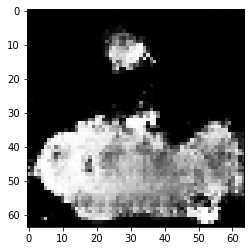

[12/15][0/117]	Loss_D: 1.2983	Loss_G: 1.2638	D(x): 0.6182	D(G(z)): 0.5304 / 0.3042
[12/15][50/117]	Loss_D: 1.3429	Loss_G: 1.1692	D(x): 0.5685	D(G(z)): 0.5128 / 0.3318


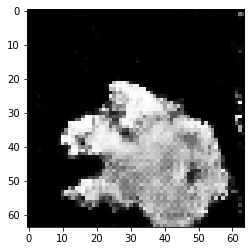

[12/15][100/117]	Loss_D: 1.3082	Loss_G: 1.0689	D(x): 0.5703	D(G(z)): 0.4981 / 0.3591
[13/15][0/117]	Loss_D: 1.3107	Loss_G: 1.2479	D(x): 0.5807	D(G(z)): 0.5058 / 0.3005
[13/15][50/117]	Loss_D: 1.1248	Loss_G: 1.4917	D(x): 0.5468	D(G(z)): 0.3746 / 0.2414


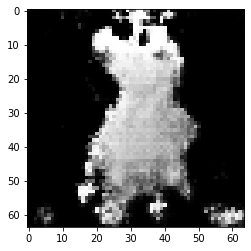

[13/15][100/117]	Loss_D: 1.0836	Loss_G: 1.1183	D(x): 0.5767	D(G(z)): 0.3868 / 0.3401
[14/15][0/117]	Loss_D: 1.2020	Loss_G: 1.0209	D(x): 0.4511	D(G(z)): 0.2823 / 0.3879
[14/15][50/117]	Loss_D: 1.3099	Loss_G: 0.7258	D(x): 0.4376	D(G(z)): 0.3356 / 0.5054


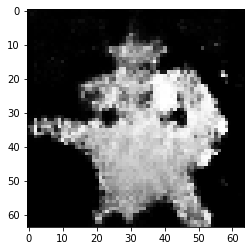

[14/15][100/117]	Loss_D: 1.1482	Loss_G: 1.1945	D(x): 0.5883	D(G(z)): 0.4404 / 0.3169


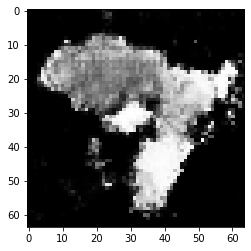

In [26]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
broke = False
lowest_G_loss = 1.0
lowest_D_loss = 1.0
best_D_of_G = 0.55
best_D_of_x = 0.1

last_best_G_loss_path = None
last_best_D_of_x_path = None

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
#         label = F.dropout(label, 0.01)
        # Forward pass real batch through D
        output = D(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = G(noise)
        label.fill_(fake_label)
#         lebal = F.dropout(label, 0.98)
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

#         if epoch > 1:
#             if errG.item() < lowest_G_loss:
#                 lowest_G_loss = errG.item()
#                 path = f"./checkpoints/best_G_loss/model_e{epoch:03}_i{i:03}.pt"
#                 save_checkpoint(path, epoch, G, optimizerG, lowest_G_loss)
#                 last_best_G_loss_path = path
            
#             if abs(D_x) - 0.5 < best_D_of_x:
#                 best_D_of_x = abs(D_x) - 0.5
#                 path = f"./checkpoints/best_D_x/model_e{epoch:03}_i{i:03}.pt"
#                 save_checkpoint(path, epoch, G, optimizerG, best_D_of_x)
#                 last_best_D_of_x_path = path
            

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                plt.imshow(np.transpose(G(torch.randn(1, nz, 1, 1, device=device)).detach().cpu()[0],(1,2,0)), cmap='Greys_r')
                plt.show()
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            

        iters += 1

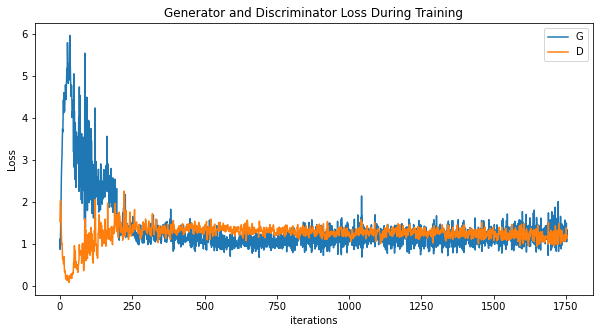

In [27]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

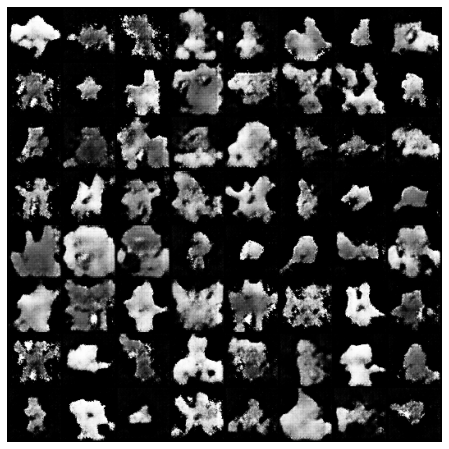

In [28]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

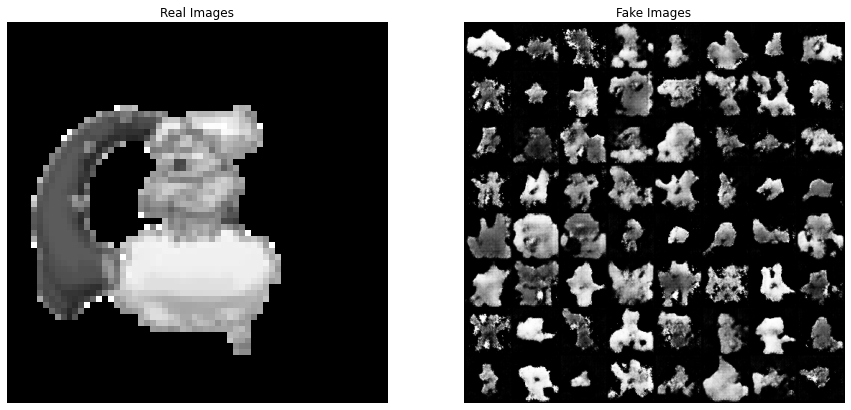

In [29]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

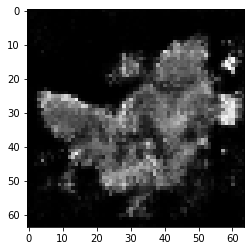

In [30]:
plt.imshow(np.transpose(G(torch.randn(b_size, nz, 1, 1, device=device)).detach().cpu()[0],(1,2,0)), cmap='Greys_r')
plt.show()
# G(torch.randn(b_size, nz, 1, 1, device=device)).detach().cpu().shape

In [31]:
def generate_image(net):
    plt.imshow(np.transpose(net(torch.randn(b_size, nz, 1, 1, device=device)).detach().cpu()[0],(1,2,0)), cmap='Greys_r')
    plt.show()

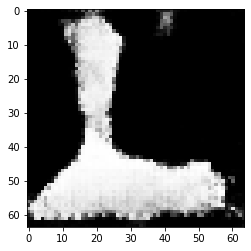

In [32]:
generate_image(G)

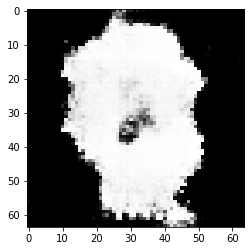

In [33]:
generate_image(G)

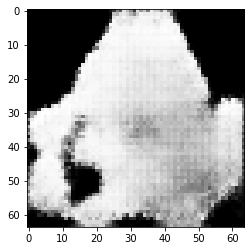

In [43]:
generate_image(G)

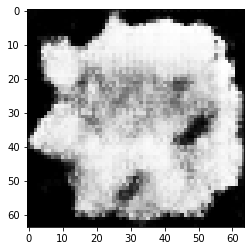

In [35]:
generate_image(G)

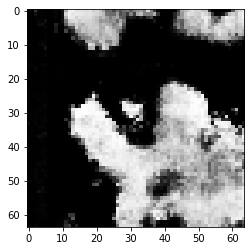

In [36]:
# img_list[-1][:,:64,:64].shape
i = 8
j = 4
plt.imshow(np.transpose(img_list[-1][:,image_size * (i-1):image_size*i,image_size*(j-1):image_size*j],(1,2,0)))
plt.show()
# G(torch.randn(b_size, nz, 1, 1, device=device)).detach().cpu().shape

In [37]:
model, optimizer, epoch, loss = load_from_checkpoint(last_best_G_loss_path, G, optimizerG)
epoch, loss

AttributeError: 'NoneType' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

In [ ]:
generate_image(model)

In [ ]:
generate_image(model)

In [ ]:
generate_image(model)

In [ ]:
model, optimizer, epoch, loss = load_from_checkpoint(last_best_D_of_x_path, G, optimizerG)
epoch, loss

In [ ]:
generate_image(model)

In [ ]:
generate_image(model)

In [ ]:
generate_image(model)